In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

In [42]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [43]:
# Load the dataset
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('sentimentdataset.csv')

Saving sentimentdataset.csv to sentimentdataset (2).csv


In [44]:
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset Shape: (732, 15)

First few rows:


,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [45]:
# Clean column names by stripping whitespace
df.columns = df.columns.str.strip()
df = df.rename(columns=lambda x: x.strip())

# Clean string columns by stripping whitespace
string_cols = ['Text', 'Sentiment', 'User', 'Platform', 'Hashtags', 'Country']
for col in string_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

In [46]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Unnamed: 0.1    0
Unnamed: 0      0
Text            0
Sentiment       0
Timestamp       0
User            0
Platform        0
Hashtags        0
Retweets        0
Likes           0
Country         0
Year            0
Month           0
Day             0
Hour            0
dtype: int64


In [47]:
# Create a datetime column from the timestamp
df['Datetime'] = pd.to_datetime(df['Timestamp'])


In [53]:
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove mentions and hashtags for analysis (keep hashtags in a separate column)
    text = re.sub(r'@\w+|\#\w+', '', text)

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Rejoin
    return ' '.join(tokens)
df['Processed_Text'] = df['Text'].apply(preprocess_text)
print("\nSample of processed text:")
print(df[['Text', 'Processed_Text']].head())



Sample of processed text:
                                          Text  \
0        Enjoying a beautiful day at the park!   
1           Traffic was terrible this morning.   
2          Just finished an amazing workout! 💪   
3  Excited about the upcoming weekend getaway!   
4  Trying out a new recipe for dinner tonight.   

                     Processed_Text  
0       enjoying beautiful day park  
1          traffic terrible morning  
2          finished amazing workout  
3  excited upcoming weekend getaway  
4  trying new recipe dinner tonight  


In [54]:
# Extract hashtags into a list
def extract_hashtags(hashtag_text):
    hashtags = re.findall(r'#\w+', hashtag_text)
    return [tag.replace('#', '').lower() for tag in hashtags]

df['Hashtag_List'] = df['Hashtags'].apply(extract_hashtags)

# Get the most common hashtags
all_hashtags = [tag for sublist in df['Hashtag_List'] for tag in sublist if tag]
hashtag_counts = pd.Series(all_hashtags).value_counts().head(20)

print("\nTop 20 hashtags:")
print(hashtag_counts)



Top 20 hashtags:
serenity         15
excitement       13
gratitude        13
despair          11
nostalgia        11
curiosity        10
contentment      10
hopeful           9
grief             9
awe               9
loneliness        9
acceptance        8
enthusiasm        8
joy               8
confusion         8
inspiration       7
determination     7
elation           7
euphoria          7
regret            6
Name: count, dtype: int64


In [55]:
# Simplified sentiment analysis (in case we want to normalize the diverse sentiment labels)
def get_sentiment_score(text):
    analysis = TextBlob(text)

    # Return polarity score (-1 to 1)
    return analysis.sentiment.polarity

# Apply TextBlob sentiment analysis to get numerical scores
df['Sentiment_Score'] = df['Processed_Text'].apply(get_sentiment_score)

In [57]:
# Map sentiment score to categories for comparison
def categorize_sentiment(score):
    if score > 0.2:
        return "Positive"
    elif score < -0.2:
        return "Negative"
    else:
        return "Neutral"

df['Sentiment_Category'] = df['Sentiment_Score'].apply(categorize_sentiment)

# Compare with the original sentiment labels
sentiment_comparison = pd.crosstab(df['Sentiment'], df['Sentiment_Category'])
print("\nOriginal vs. Calculated Sentiment:")
print(sentiment_comparison)

# Group sentiments into broader categories for analysis
positive_sentiments = ['Positive', 'Joy', 'Happiness', 'Excitement', 'Love', 'Contentment', 'Hope',
                      'Pride', 'Gratitude', 'Enthusiasm', 'Happy']


Original vs. Calculated Sentiment:
Sentiment_Category  Negative  Neutral  Positive
Sentiment                                      
Acceptance                 0        7         1
Accomplishment             0        0         3
Admiration                 0        2         2
Adoration                  0        0         2
Adrenaline                 0        1         0
...                      ...      ...       ...
Winter Magic               0        0         1
Wonder                     0        3         0
Wonderment                 0        1         0
Yearning                   1        1         0
Zest                       0        0         2

[191 rows x 3 columns]


In [59]:
def categorize_original_sentiment(sentiment):
    sentiment = sentiment.strip()
    if any(pos in sentiment for pos in positive_sentiments):
        return "Positive"
    elif any(neg in sentiment for neg in negative_sentiments):
        return "Negative"
    elif any(neu in sentiment for neu in neutral_sentiments):
        return "Neutral"
    else:
        return None
df['Broad_Sentiment'] = df['Sentiment'].apply(categorize_original_sentiment)
df['Broad_Sentiment'] = df['Broad_Sentiment'].fillna(df['Sentiment_Category'])

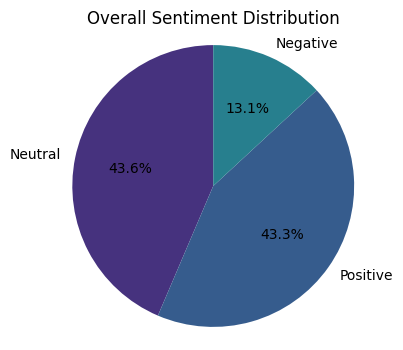

In [101]:
# Overall sentiment distribution
import matplotlib.pyplot as plt

sentiment_counts = df['Broad_Sentiment'].value_counts()
sentiment_percentages = (sentiment_counts / sentiment_counts.sum()) * 100

plt.figure(figsize=(4, 4))
plt.pie(sentiment_percentages, labels=sentiment_percentages.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))
plt.title('Overall Sentiment Distribution')
plt.axis('equal')
plt.show()



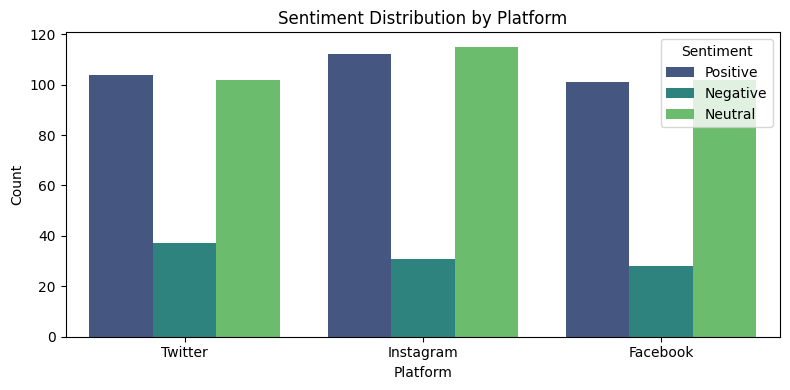

In [100]:
# Sentiment distribution by platform
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Platform', hue='Broad_Sentiment', palette='viridis')
plt.title('Sentiment Distribution by Platform')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


<Figure size 1600x900 with 0 Axes>

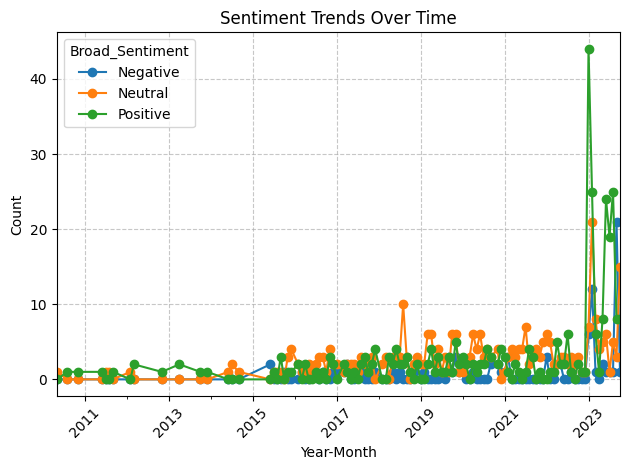

In [98]:
# Sentiment over time
df['YearMonth'] = df['Datetime'].dt.to_period('M')
sentiment_over_time = df.groupby(['YearMonth', 'Broad_Sentiment']).size().unstack(fill_value=0)

plt.figure(figsize=(16, 9))
sentiment_over_time.plot(kind='line', marker='o')
plt.title('Sentiment Trends Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Average engagement by sentiment:
                  Retweets      Likes
Broad_Sentiment                      
Negative         18.093750  36.041667
Neutral          20.843260  41.595611
Positive         23.211356  46.293375


<Figure size 1000x600 with 0 Axes>

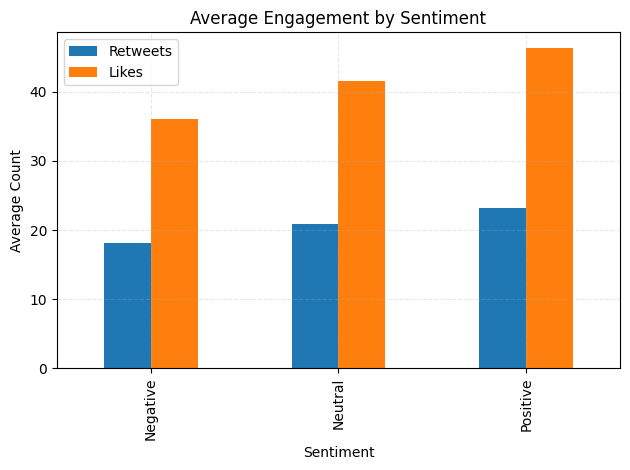

In [97]:
# Engagement analysis
engagement_by_sentiment = df.groupby('Broad_Sentiment')[['Retweets', 'Likes']].mean()
print("\nAverage engagement by sentiment:")
print(engagement_by_sentiment)

plt.figure(figsize=(10, 6))
engagement_by_sentiment.plot(kind='bar')
plt.title('Average Engagement by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Count')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

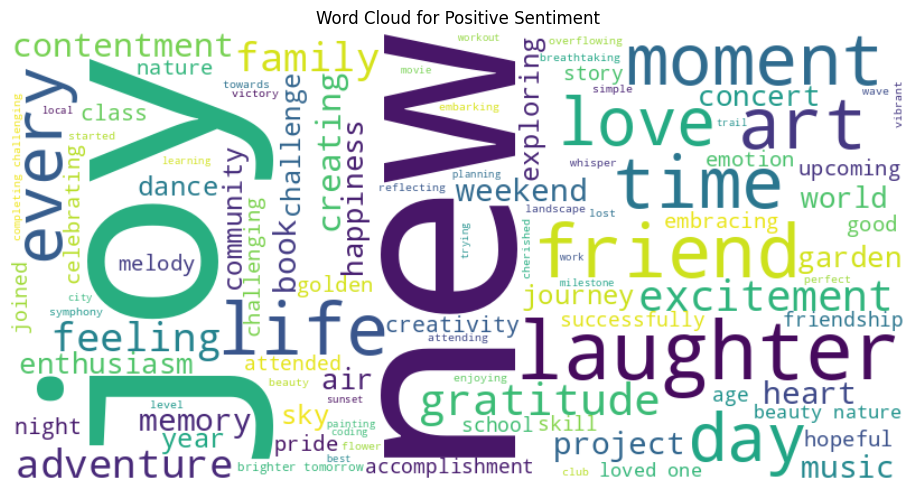

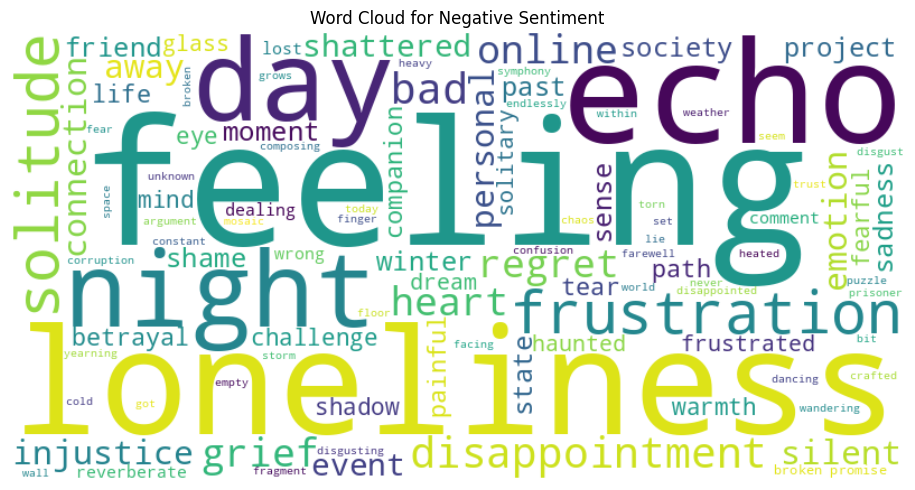

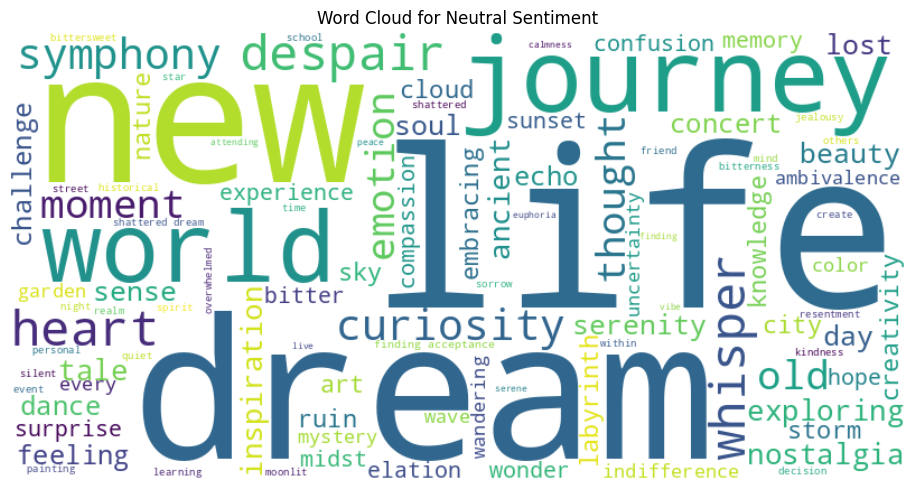

In [96]:
# Word clouds for different sentiments
def generate_wordcloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          max_words=100,
                          colormap='viridis').generate(' '.join(text_data))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()
# Generate word clouds for each sentiment
for sentiment in ['Positive', 'Negative', 'Neutral']:
    text_data = df[df['Broad_Sentiment'] == sentiment]['Processed_Text']
    generate_wordcloud(text_data, f'Word Cloud for {sentiment} Sentiment')

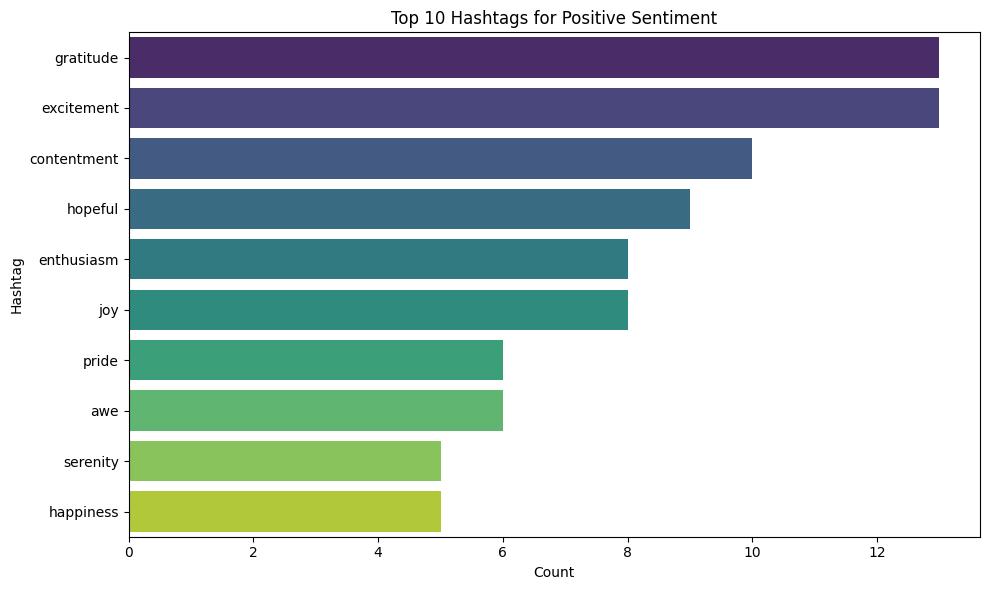

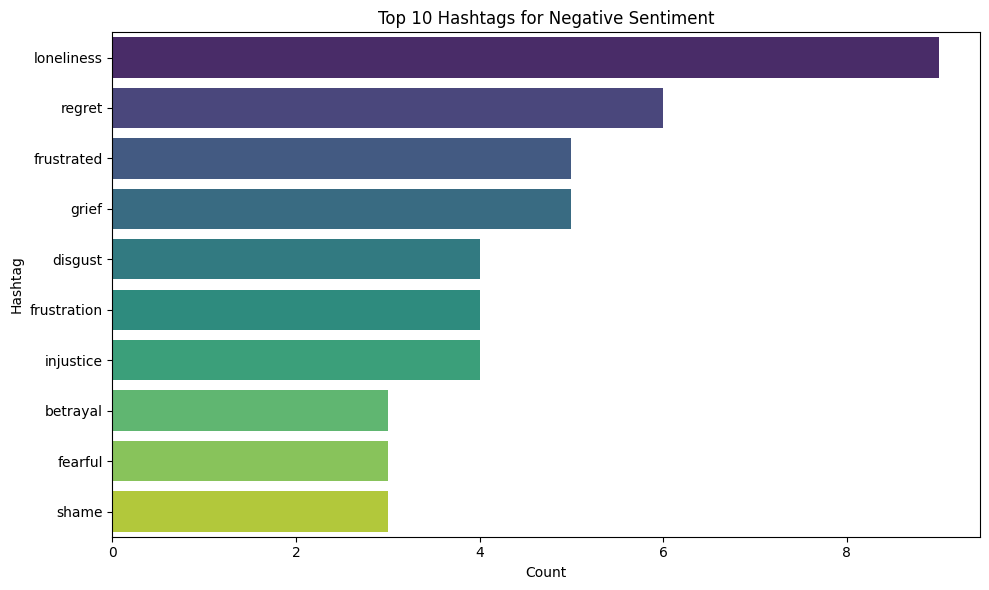

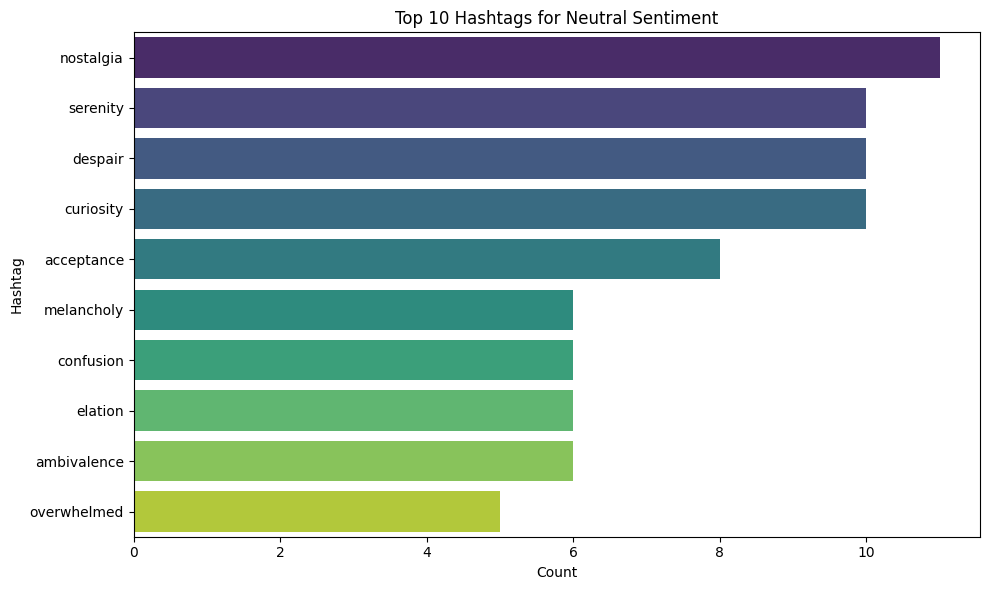

In [95]:
# Hashtag analysis by sentiment
def plot_top_hashtags_by_sentiment(sentiment, n=10):
    # Filter data by sentiment
    data = df[df['Broad_Sentiment'] == sentiment]

    # Get all hashtags for this sentiment
    hashtags = [tag for sublist in data['Hashtag_List'] for tag in sublist if tag]

    if not hashtags:  # Skip if no hashtags
        return

    # Count and get top N
    top_hashtags = pd.Series(hashtags).value_counts().head(n)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_hashtags.values, y=top_hashtags.index, palette='viridis')
    plt.title(f'Top {n} Hashtags for {sentiment} Sentiment')
    plt.xlabel('Count')
    plt.ylabel('Hashtag')
    plt.tight_layout()
    plt.show()

# Plot top hashtags for each sentiment
for sentiment in ['Positive', 'Negative', 'Neutral']:
    plot_top_hashtags_by_sentiment(sentiment)


<Figure size 1200x800 with 0 Axes>

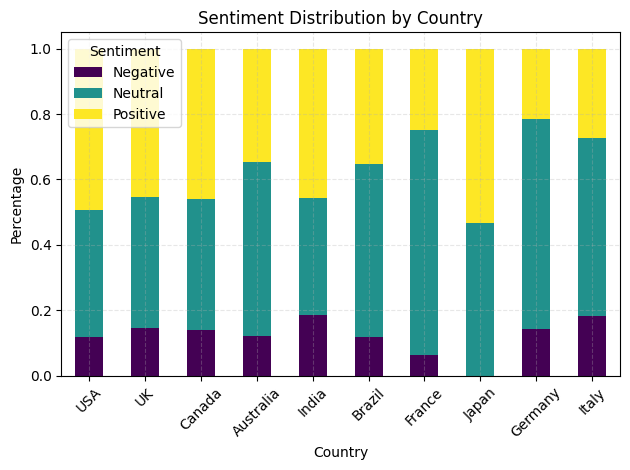

In [94]:
# Sentiment by country
plt.figure(figsize=(12, 8))
country_sentiment = pd.crosstab(df['Country'], df['Broad_Sentiment'])
country_sentiment_pct = country_sentiment.div(country_sentiment.sum(axis=1), axis=0)

min_posts = 10
top_countries = df['Country'].value_counts()[df['Country'].value_counts() >= min_posts].index
country_sentiment_pct = country_sentiment_pct.loc[top_countries]

country_sentiment_pct.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Sentiment Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


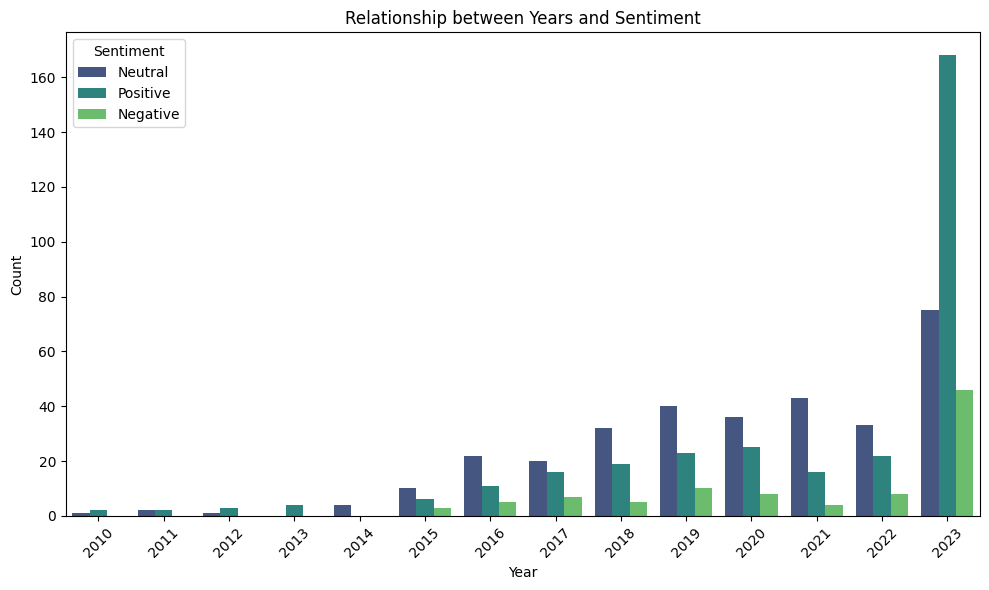

In [93]:
# Relationship between Years and Sentiment

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x=df['Datetime'].dt.year, hue='Broad_Sentiment', palette='viridis')
plt.title('Relationship between Years and Sentiment')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


In [92]:
# Topic modeling for each sentiment category
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer

def perform_topic_modeling(texts, n_topics=5, n_top_words=10):
    # Create a vectorizer
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

    # Create document-term matrix
    dtm = vectorizer.fit_transform(texts)

    # Get feature names
    feature_names = vectorizer.get_feature_names_out()

    # Create and fit the LDA model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)

    # Print top words for each topic
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic #{topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print("\n")

# Perform topic modeling for each sentiment
for sentiment in ['Positive', 'Negative', 'Neutral']:
    print(f"\nTopic Modeling for {sentiment} Sentiment:")
    texts = df[df['Broad_Sentiment'] == sentiment]['Processed_Text']

    # Only perform topic modeling if there are enough documents
    if len(texts) > 10:
        perform_topic_modeling(texts)
    else:
        print("Not enough documents for reliable topic modeling")




Topic Modeling for Positive Sentiment:
Topic #1:
nature beauty garden moment bloom time gratitude friend joy contentment
Topic #2:
hopeful joy friend new surprise excitement heart gratitude friendship party
Topic #3:
day music love upcoming challenging laughter time attended moment like
Topic #4:
happiness new life dance story contentment feeling embarking journey spirit
Topic #5:
new joy art book project exploring creating world success achievement



Topic Modeling for Negative Sentiment:
Topic #1:
day bad feeling event broken promise challenge painful sadness life
Topic #2:
emotion frustration personal friend moment shame winter injustice warmth project
Topic #3:
regret fearful shadow mind path haunted past eye betrayal lost
Topic #4:
loneliness solitude night echo online silent feeling companion solitary connection
Topic #5:
like disappointment grief shattered glass echo frustration society dream tear



Topic Modeling for Neutral Sentiment:
Topic #1:
sky life curiosity knowledge 

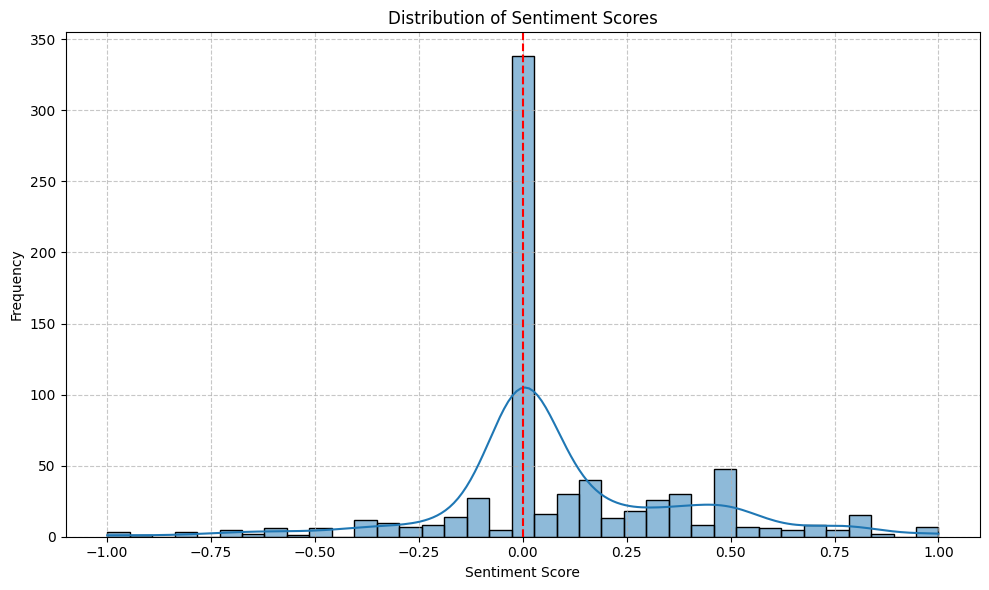

In [91]:
# Sentiment score distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Sentiment_Score'], kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



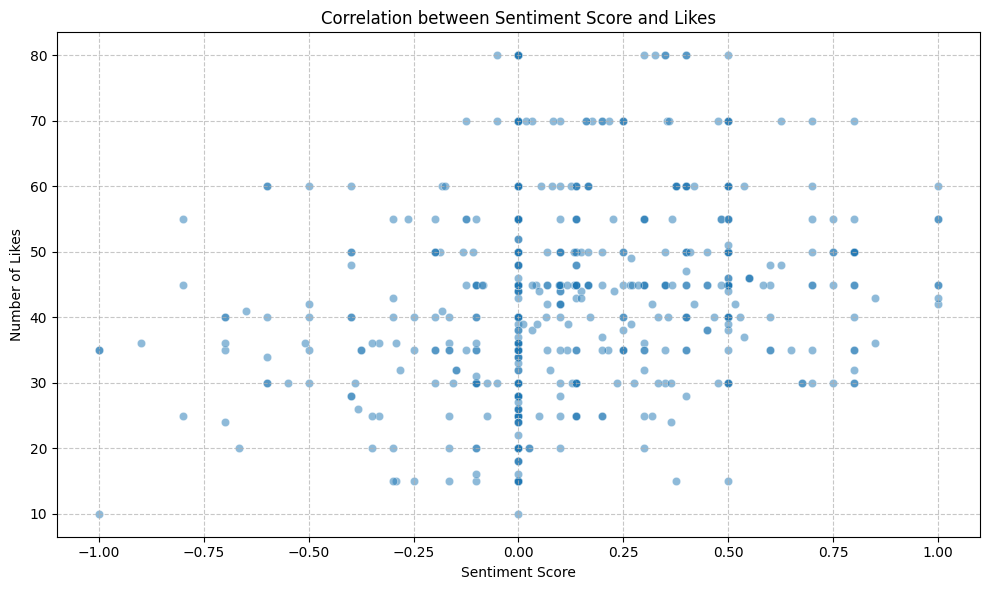

In [90]:
# Correlation between engagement and sentiment
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Sentiment_Score', y='Likes', alpha=0.5)
plt.title('Correlation between Sentiment Score and Likes')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Likes')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [89]:
# Display summary statistics
print("\nSummary of Sentiment Analysis:")
print(f"Total posts analyzed: {len(df)}")
print(f"Positive posts: {len(df[df['Broad_Sentiment'] == 'Positive'])} ({len(df[df['Broad_Sentiment'] == 'Positive'])/len(df)*100:.1f}%)")
print(f"Negative posts: {len(df[df['Broad_Sentiment'] == 'Negative'])} ({len(df[df['Broad_Sentiment'] == 'Negative'])/len(df)*100:.1f}%)")
print(f"Neutral posts: {len(df[df['Broad_Sentiment'] == 'Neutral'])} ({len(df[df['Broad_Sentiment'] == 'Neutral'])/len(df)*100:.1f}%)")


Summary of Sentiment Analysis:
Total posts analyzed: 732
Positive posts: 317 (43.3%)
Negative posts: 96 (13.1%)
Neutral posts: 319 (43.6%)
